In [2]:
pip install tensorflow==2.15.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 71.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 56.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 111.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 8.1 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.0
    Uninstalling ml-dtypes-0.4.0:
      Successfully uninstalled ml-dtypes-0.4.0
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: tensorboard
    Found existing installatio

In [3]:
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.applications import VGG16
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support, accuracy_score
import seaborn as sns
import os

In [4]:
IMAGE_SIZE_1 = 224
IMAGE_SIZE_2 = 224
BATCH_SIZE = 32
EPOCHS = 50
CHANNELS = 3
NUM_CLASSES = 27  # Adjust this based on your dataset
DATASET_PATH = "/content/drive/MyDrive/PharmaScope"

In [5]:
# Load dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_PATH,
    shuffle=True,
    image_size=(IMAGE_SIZE_1, IMAGE_SIZE_2),
    batch_size=BATCH_SIZE
)

Found 3495 files belonging to 27 classes.


In [6]:
# Get class names
class_names = dataset.class_names

In [7]:
# Split dataset into train, validation, and test sets
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds


train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [8]:
# Cache, shuffle, and prefetch the datasets
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [9]:
# Data augmentation
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [10]:
# Build the model using VGG16
vgg16 = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(IMAGE_SIZE_1, IMAGE_SIZE_2, CHANNELS)
)

58889256/58889256 [==============================] - 4s 0us/step


In [11]:
for layer in vgg16.layers:
    layer.trainable = False

model = models.Sequential([
    data_augmentation,
    vgg16,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),  # Regularization
    layers.Dense(NUM_CLASSES, activation='softmax')
])

In [12]:
# Build the model with the correct input shape
model.build(input_shape=(None, IMAGE_SIZE_1, IMAGE_SIZE_2, CHANNELS))

In [13]:
# Model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 27)                13851     
                                                      

In [14]:
# Compile the model
model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [15]:
# Train the model
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
88/88 [==============================] - 455s 3s/step - loss: 1.9993 - accuracy: 0.4686 - val_loss: 0.7164 - val_accuracy: 0.7955
Epoch 2/50
88/88 [==============================] - 9s 107ms/step - loss: 0.8747 - accuracy: 0.7198 - val_loss: 0.4926 - val_accuracy: 0.8665
Epoch 3/50
88/88 [==============================] - 9s 107ms/step - loss: 0.6130 - accuracy: 0.8029 - val_loss: 0.2897 - val_accuracy: 0.9347
Epoch 4/50
88/88 [==============================] - 9s 108ms/step - loss: 0.4700 - accuracy: 0.8545 - val_loss: 0.2162 - val_accuracy: 0.9460
Epoch 5/50
88/88 [==============================] - 10s 109ms/step - loss: 0.3951 - accuracy: 0.8685 - val_loss: 0.1921 - val_accuracy: 0.9517
Epoch 6/50
88/88 [==============================] - 10s 111ms/step - loss: 0.3323 - accuracy: 0.8939 - val_loss: 0.1672 - val_accuracy: 0.9460
Epoch 7/50
88/88 [==============================] - 10s 110ms/step - loss: 0.2509 - accuracy: 0.9201 - val_loss: 0.1083 - val_accuracy: 0.9773
Epoc

In [ ]:
# Evaluate the model
scores = model.evaluate(test_ds)
print(f'Test Accuracy: {scores[1]}')


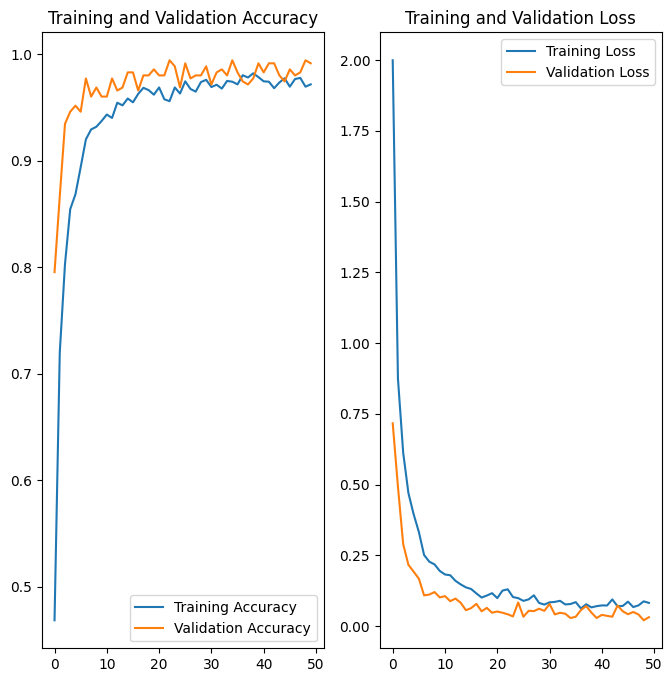

In [ ]:
# Plot training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Make predictions
y_true = []
y_pred = []

for images_batch, labels_batch in test_ds:
    y_true.extend(labels_batch.numpy())
    preds = model.predict(images_batch)
    y_pred.extend(np.argmax(preds, axis=1))

In [ ]:
# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix")
print(cm)

In [ ]:
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')


In [ ]:
# Smooth the training and validation accuracy and loss
window_size = 11  # Adjust the window size for more or less smoothing
smooth_acc = moving_average(acc, window_size)
smooth_val_acc = moving_average(val_acc, window_size)
smooth_loss = moving_average(loss, window_size)
smooth_val_loss = moving_average(val_loss, window_size)

# Adjust the range to match the smoothed data
smooth_range = range(len(smooth_acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(smooth_range, smooth_acc, label='Training Accuracy')
plt.plot(smooth_range, smooth_val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('raining and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(smooth_range, smooth_loss, label='Training Loss')
plt.plot(smooth_range, smooth_val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [ ]:
# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Classification report
cr = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report")
print(cr)

In [ ]:
# Precision, recall, F1 score, and accuracy
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
accuracy = accuracy_score(y_true, y_pred)

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1_score}')
print(f'Accuracy: {accuracy}')

In [ ]:
model.save(f"/content/drive/MyDrive/CorrectOnes/VGG2.h5") # Add '.keras' extension for saving